In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Classification problem with HWW ATLAS Open data using Machine Learning

In this exercise you are given 3 files with tabular data split by 3 sets, respectively:

 * Set of events for training the ML classifier (data_train.csv)
 * Set of events for validating the ML classifier (data_val.csv)
 * Set of events for testing the ML classifier (data_test.csv)

The data content is the same used for the ML class, i.e.

 * there is a number of observables (mLL,pTLL, etc...);
 * a label indicating the true class of each event (0=background, 1=signal) included as a variable in the data frame;
 * an event weight to be used for training ("train_weight").

## Load and inspect data

* Open data files
* Inspect contents
* Plot variables

In [2]:
data_train = pd.read_csv("https://www.lip.pt/~rute/MASimHEP/HWW_csv_prep/data_train.csv")
data_val   = pd.read_csv("https://www.lip.pt/~rute/MASimHEP/HWW_csv_prep/data_val.csv")
data_test  = pd.read_csv("https://www.lip.pt/~rute/MASimHEP/HWW_csv_prep/data_test.csv")

data_train

,Unnamed: 0,mLL,ptLL,dPhi_LL,dPhiLLmet,MET,mt,goodjet_n,goodbjet_n,Lepton1_Pt,...,Lepton2_Eta,Lepton2_E,Lepton2_Phi,Lepton2_charge,Lepton2_type,weight,process,label,scale_weight,train_weight
0,147358,49.0513,61.2491,1.381790,3.02321,67.4356,128.3110,0,0,47.4727,...,-1.721170,88.8479,-0.235791,-1,11,0.988994,diboson,0,0.024622,0.000016
1,5771,19.9963,57.7996,0.699216,2.46491,61.4980,112.4800,1,0,40.3348,...,1.846730,67.4742,2.171550,1,11,31.823900,signal,1,0.003327,0.000016
2,76660,43.8206,96.2837,0.084119,2.31188,84.7958,165.3850,1,0,61.2737,...,0.502883,39.6200,-0.597652,-1,11,25.705100,signal,1,0.002687,0.000013
3,154078,49.4911,85.4053,1.037550,2.22171,93.4773,160.1300,1,0,61.2571,...,-0.131749,36.3402,-2.929180,-1,13,0.084681,diboson,0,0.002108,0.000001
4,73055,33.0773,60.7330,1.009950,2.83851,42.6602,100.6350,1,0,40.1756,...,0.329813,30.5285,2.296100,1,11,32.887200,signal,1,0.003438,0.000016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64055,5014,44.2874,59.5597,0.489036,2.80323,39.1230,95.1650,0,0,35.7962,...,0.418980,27.8105,1.029180,1,11,0.000000,signal,1,0.000000,0.000000
64056,173819,22.4984,68.0981,0.636690,2.88861,91.2377,156.3870,0,0,42.8521,...,2.259050,138.8700,-0.802207,1,13,0.981583,diboson,0,0.024438,0.000016
64057,153656,22.7315,61.5826,0.317995,3.08785,63.8451,125.3620,0,0,38.6547,...,-2.249690,113.4920,2.326470,-1,13,1.192730,diboson,0,0.029694,0.000020
64058,187006,42.2915,55.7519,0.391131,2.96568,29.7256,81.1042,0,0,39.6714,...,-0.463672,18.8450,2.831800,-1,13,1.180240,diboson,0,0.029383,0.000020


In [ ]:
features = data_train.columns
features

Index(['Unnamed: 0', 'mLL', 'ptLL', 'dPhi_LL', 'dPhiLLmet', 'MET', 'mt',
       'goodjet_n', 'goodbjet_n', 'Lepton1_Pt', 'Lepton1_Eta', 'Lepton1_E',
       'Lepton1_Phi', 'Lepton1_charge', 'Lepton1_type', 'Lepton2_Pt',
       'Lepton2_Eta', 'Lepton2_E', 'Lepton2_Phi', 'Lepton2_charge',
       'Lepton2_type', 'weight', 'process', 'label', 'scale_weight',
       'train_weight'],
      dtype='object')

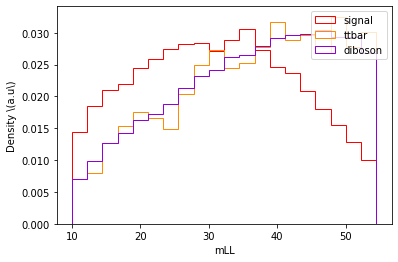

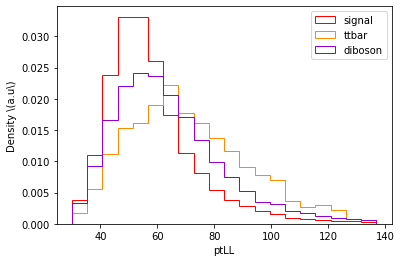

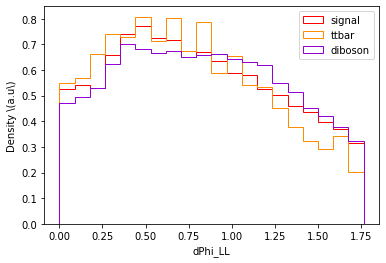

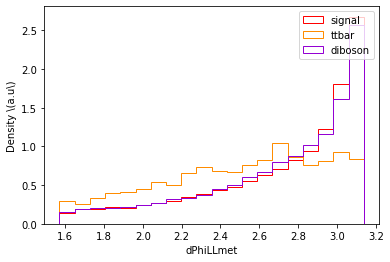

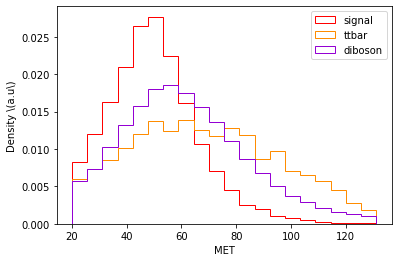

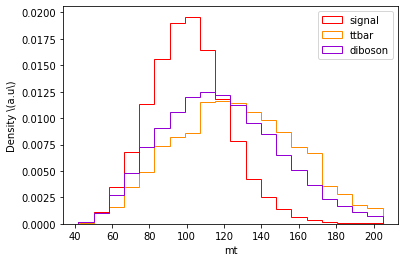

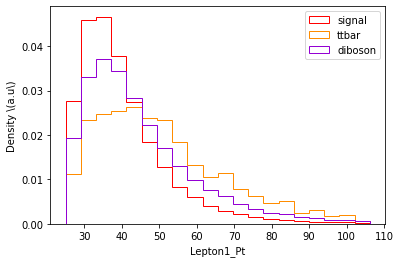

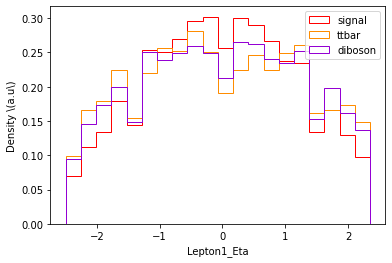

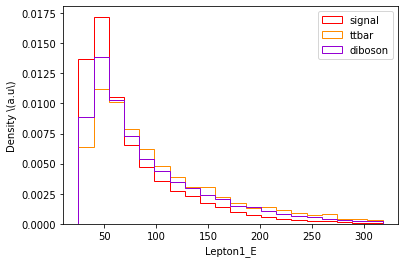

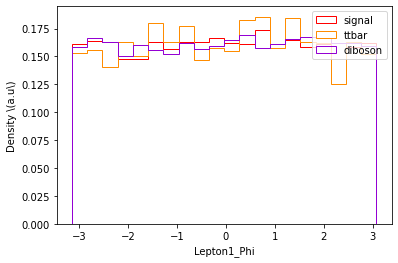

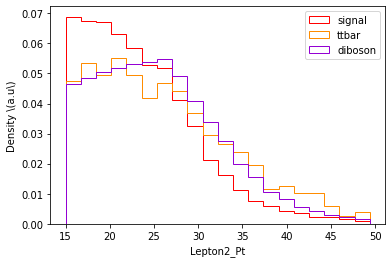

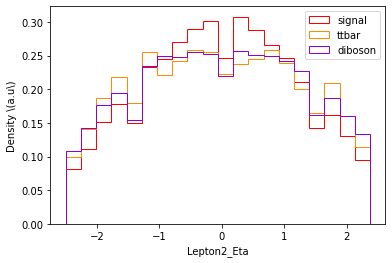

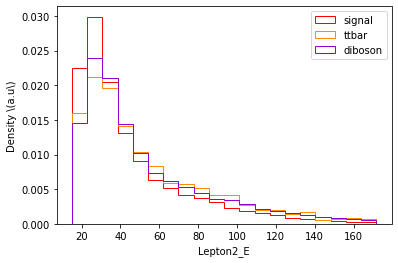

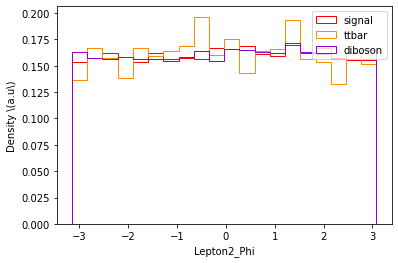

In [ ]:
plot_features = ['mLL', 'ptLL', 'dPhi_LL', 'dPhiLLmet', 'MET', 'mt',
                 'Lepton1_Pt', 'Lepton1_Eta', 'Lepton1_E', 'Lepton1_Phi',
                 'Lepton2_Pt', 'Lepton2_Eta', 'Lepton2_E', 'Lepton2_Phi']

for feat in plot_features:

    #(We are filtering data signal out of the 99% quantile to get the bulk of the distribution and obtain decent axes limits...)
    bins = plt.hist(data_train.query(f'({feat} < {feat}.quantile(.99)) & (process=="signal")')[feat].values, bins=20, density=True, histtype='step', color='red', label='signal')
    plt.hist(data_train.query('process=="ttbar"')[feat].values, bins=bins[1], density=True, histtype='step', color='darkorange', label='ttbar')
    plt.hist(data_train.query('process=="diboson"')[feat].values, bins=bins[1], density=True, histtype='step', color='darkviolet', label='diboson')

    plt.xlabel(feat)
    plt.ylabel('Density \(a.u\)')
    plt.legend()
    #plt.yscale("log")
    plt.show()

## Data pre-processing for training

* Define training 'features'
* Construct the inputs (x_train,x_val), weights (w_train,w_val) and target values (y_train,y_val) to train the classifier (in this step you obtain the exact same arrays as used in the ML class)

In [ ]:
train_features = ['mLL', 'ptLL', 'dPhi_LL', 'dPhiLLmet', 'MET', 'mt', 'goodjet_n',
                 'goodbjet_n', 'Lepton1_Pt', 'Lepton1_Eta', 'Lepton1_E', 'Lepton1_Phi',
                 'Lepton1_charge', 'Lepton1_type', 'Lepton2_Pt', 'Lepton2_Eta',
                 'Lepton2_E', 'Lepton2_Phi', 'Lepton2_charge', 'Lepton2_type']

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_train[train_features].values)

x_train = scaler.transform(data_train[train_features].values)
y_train = data_train['label'].values
w_train = data_train['train_weight'].values

x_val = scaler.transform(data_val[train_features].values)
y_val = data_val['label'].values
w_val = data_val['train_weight'].values

x_test = scaler.transform(data_test[train_features].values)
y_test = data_test['label'].values
w_test = data_test['train_weight'].values

print(f'Train sample x {len(x_train)} events (y {len(y_train)} events)')
print(f'Val   sample x {len(x_val)} events (y {len(y_val)} events)')
print(f'Test  sample x {len(x_test)} events (y {len(y_test)} events)')

Train sample x 64060 events (y 64060 events)
Val   sample x 64060 events (y 64060 events)
Test  sample x 64060 events (y 64060 events)


# Exercise 1: DNN - Deep Neural Network Classifier


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.random.set_seed(2)

## 1.a) DNN Training

Train a DNN with the hyperparameters below:

* 3 layers with 80, 95, 70 nodes respectively
* Learning rate of 8e-4
* 100 training epochs and Early Stopping with patience 4

In [ ]:
# your answer

## 1.b) Evaluate the DNN

* Plot the DNN output for signal and background and the Receiver Operating Characteristic (ROC) curve.
* What is the ROC Area Under the Curve (AUC)?

In [ ]:
# your answer

# Exercise 2: RF - Random Forest Classifier


## 2.a) RF Training

Train a Random Forest Classifier with the hyperparameters below:

* Maximum depth of 3
* 40 decision trees (estimators)

**HINT:** The method to retreive the class prediction from the classifier for an input set of data x

```
predict_proba(x)
```
returns the probabilities of classification according to each class (0 or 1), such that

```
predict_proba(x)[:,0] # class-0 probability
predict_proba(x)[:,1] # class-1 probability
```




In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# your answer

## 2.b) Evaluate the RF

* Plot the classifier output for signal and background and the Receiver Operating Characteristic (ROC) curve.
* What is the ROC Area Under the Curve (AUC)?

In [ ]:
# your answer

# Exercise 3: DNN versus RF

Which method (DNN or Random Forest) has the best classification performance? Are these results in agreement with your expectations? Explain why.



Answer: